#  Forecasting Monthly EV Sales


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Preprocessing

In [4]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

In [5]:
lag_time_features = [f'TVV_Lag{i}' for i in range(1, 7)] + ['year', 'month', 'quarter']
feature_sets = {
    'Lag Only': lag_time_features,
    'All Features': [col for col in df_lagged.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]


}


# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features


### Split

In [6]:
def walk_forward_validation_with_validation_set(df, features, target_col, model_fn, forecast_horizon=3, validation_size=None):
    """
    Voert walk-forward validatie uit met een expliciete validatieset en expanding window splits.
    Parameters:
        df (pd.DataFrame): De dataframe met de features en de target kolom.
        features (list): Een lijst met kolomnamen die als features worden gebruikt.
        target_col (str): De naam van de kolom die als target wordt gebruikt.
        model_fn (callable): Een functie die een nieuw, ongefit model object retourneert (bijv. lambda: LinearRegression()).
        forecast_horizon (int): Het aantal stappen vooruit dat voorspeld moet worden. Standaard is 3.
        validation_size (int, optional): Het aantal observaties in de validatieset voor elke split.
                                         Als None, wordt de validatieset overgeslagen en werkt het als de originele walk-forward.
    Returns:
        tuple: (mae, rmse, r2, mape, test_predictions, test_actuals, val_mae, val_rmse, val_r2, val_mape, validation_predictions, validation_actuals, validation_dates)
    """
    X = df[features].values
    y = df[target_col].values

    if validation_size is not None:
        min_initial_train_size = forecast_horizon + validation_size
    else:
        min_initial_train_size = forecast_horizon

    initial_train_size = max(int(len(df) * 0.8), min_initial_train_size)

    test_predictions, test_actuals = [], []
    validation_predictions, validation_actuals = [], []
    validation_dates = []

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        X_train, y_train = X[:i], y[:i]

        if validation_size is not None:
            X_val = X[i : i + validation_size]
            y_val = y[i : i + validation_size]

            if (i + validation_size + forecast_horizon - 1) >= len(df):
                break

            X_test = X[i + validation_size : i + validation_size + forecast_horizon]
            y_test = y[i + validation_size : i + validation_size + forecast_horizon]
        else:
            X_test = X[i : i + forecast_horizon]
            y_test = y[i : i + forecast_horizon]
            if (i + forecast_horizon - 1) >= len(df):
                break

        model = model_fn()
        model.fit(X_train, y_train)

        if validation_size is not None and len(X_val) > 0:
            val_preds = model.predict(X_val)
            validation_predictions.extend(val_preds)
            validation_actuals.extend(y_val)
            validation_dates.extend(df.iloc[i:i+validation_size]['Periode'].values)

        if len(X_test) > 0:
            test_preds = model.predict(X_test)
            test_predictions.extend(test_preds)
            test_actuals.extend(y_test)

    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)
    validation_predictions = np.array(validation_predictions)
    validation_actuals = np.array(validation_actuals)

    if len(test_actuals) > 0:
        mae = mean_absolute_error(test_actuals, test_predictions)
        rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        r2 = r2_score(test_actuals, test_predictions)
        mape = mean_absolute_percentage_error(test_actuals, test_predictions)
    else:
        mae, rmse, r2, mape = np.nan, np.nan, np.nan, np.nan

    val_mae, val_rmse, val_r2, val_mape = np.nan, np.nan, np.nan, np.nan
    if validation_size is not None and len(validation_actuals) > 0:
        val_mae = mean_absolute_error(validation_actuals, validation_predictions)
        val_rmse = np.sqrt(mean_squared_error(validation_actuals, validation_predictions))
        val_r2 = r2_score(validation_actuals, validation_predictions)
        val_mape = mean_absolute_percentage_error(validation_actuals, validation_predictions)

    return (mae, rmse, r2, mape, test_predictions, test_actuals,
            val_mae, val_rmse, val_r2, val_mape, validation_predictions, validation_actuals, validation_dates)


nctie om de metrics per blok (dus per forecast-horizon, bijvoorbeeld 3 maanden vooruit) te berekenen.

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def metrics_per_block(y_true, y_pred, block_size):
    """
    Bereken metrics per blok (bijv. per 3 maanden vooruit).
    Returns een lijst met dicts per blok.
    """
    n_blocks = len(y_true) // block_size
    results = []
    for i in range(n_blocks):
        start = i * block_size
        end = start + block_size
        y_true_block = y_true[start:end]
        y_pred_block = y_pred[start:end]
        results.append({
            'block': i+1,
            'mae': mean_absolute_error(y_true_block, y_pred_block),
            'rmse': np.sqrt(mean_squared_error(y_true_block, y_pred_block)),
            'r2': r2_score(y_true_block, y_pred_block),
            'mape': mean_absolute_percentage_error(y_true_block, y_pred_block)
        })
    return results

# Voorbeeldgebruik na je walk_forward_validation_with_validation_set:
# Stel je hebt val_actuals en val_preds van je validatie, en je forecast_horizon=3

block_metrics = metrics_per_block(val_actuals, val_preds, block_size=3)
for bm in block_metrics:
    print(f"Block {bm['block']}: MAE={bm['mae']:.2f}, RMSE={bm['rmse']:.2f}, R²={bm['r2']:.3f}, MAPE={bm['mape']:.4f}")

Block 1: MAE=1613.65, RMSE=1968.25, R²=-50.801, MAPE=0.1086
Block 2: MAE=1585.67, RMSE=1930.98, R²=-79.010, MAPE=0.1055
Block 3: MAE=1924.43, RMSE=2064.52, R²=-8.610, MAPE=0.1250
Block 4: MAE=5364.97, RMSE=7853.02, R²=-0.435, MAPE=0.2071
Block 5: MAE=6503.40, RMSE=8225.33, R²=-0.766, MAPE=0.2745
Block 6: MAE=6597.27, RMSE=8156.37, R²=-0.230, MAPE=0.2980
Block 7: MAE=7646.70, RMSE=7884.65, R²=-7.932, MAPE=0.4777
Block 8: MAE=2512.32, RMSE=2683.07, R²=-0.019, MAPE=0.1619
Block 9: MAE=3107.06, RMSE=3252.54, R²=-6.878, MAPE=0.1840
Block 10: MAE=2451.92, RMSE=2873.69, R²=-3.855, MAPE=0.1494
Block 11: MAE=2933.47, RMSE=3411.82, R²=-5.734, MAPE=0.1794
Block 12: MAE=3038.72, RMSE=3506.55, R²=-10.923, MAPE=0.1765
Block 13: MAE=4483.90, RMSE=4560.55, R²=-34.585, MAPE=0.2720
Block 14: MAE=4713.91, RMSE=4746.66, R²=-17.174, MAPE=0.2981
Block 15: MAE=4881.43, RMSE=5099.34, R²=-241.685, MAPE=0.3192
Block 16: MAE=5757.22, RMSE=6148.09, R²=-2.163, MAPE=0.3201
Block 17: MAE=4987.90, RMSE=5562.06, R²=-2

### LR

Linear Regression ( (Lag Only)): MAPE=0.1121, MAE=2412.88, RMSE=3414.63, R²=0.535


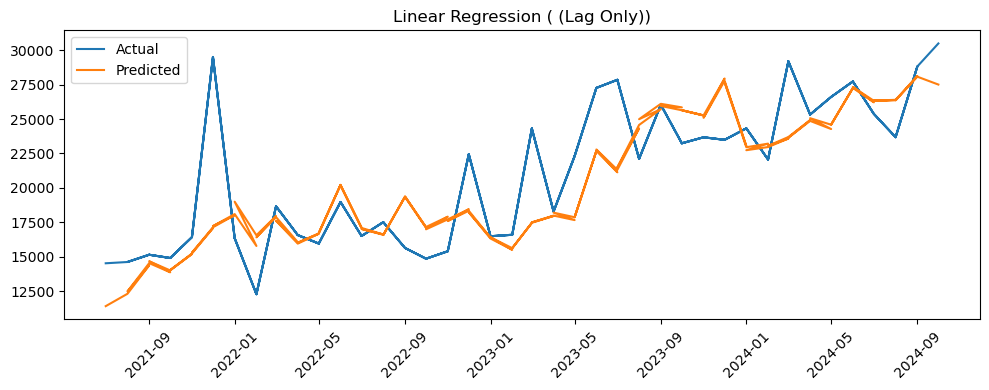

Linear Regression (All Features): MAPE=0.1630, MAE=3309.41, RMSE=4385.07, R²=0.234


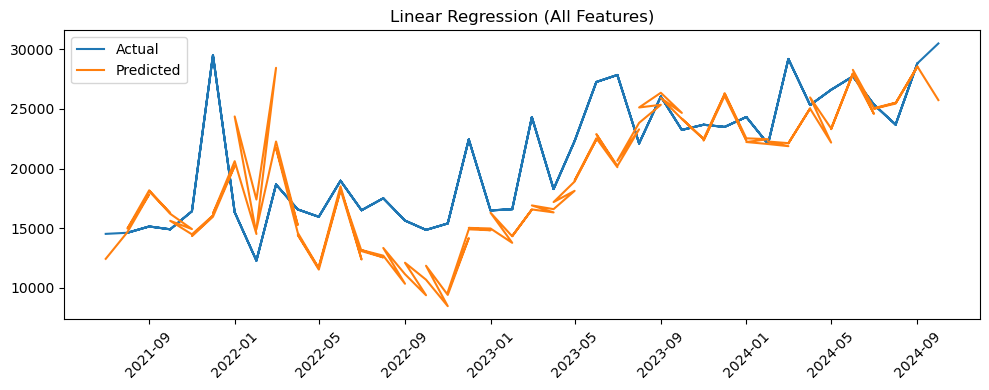

In [17]:
# Alleen de labels " (Lag Only)" en "All Features" verwerken
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=3, forecast_horizon=3	
        
    )

    print(f"Linear Regression ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(validation_dates, val_actuals, label='Actual')
    plt.plot(validation_dates, val_preds, label='Predicted')
    plt.title(f'Linear Regression ({label})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Alles printen

Linear Regression ( (Lag Only)): MAPE=0.1121, MAE=2412.88, RMSE=3414.63, R²=0.535


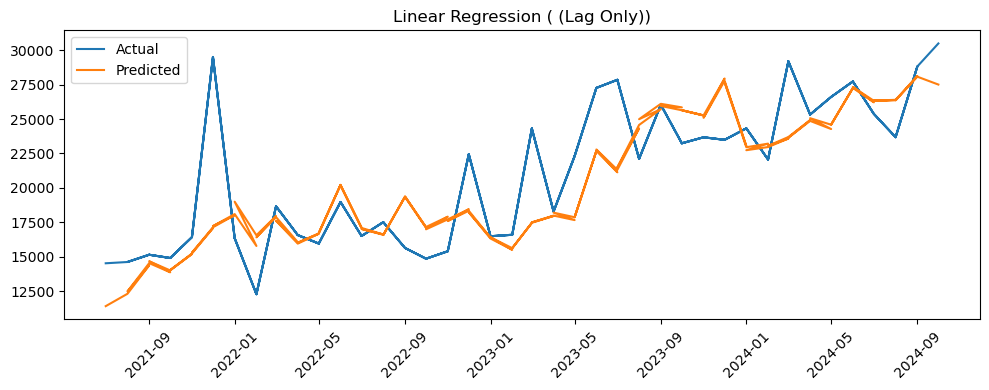

Linear Regression (Keywords + Lag): MAPE=0.1357, MAE=2923.84, RMSE=4180.01, R²=0.304


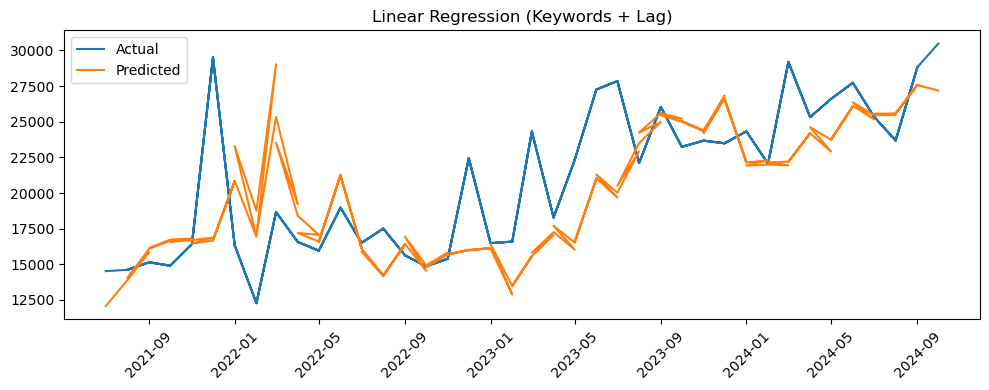

Linear Regression (Bijtelling + Lag): MAPE=0.1122, MAE=2416.27, RMSE=3418.47, R²=0.534


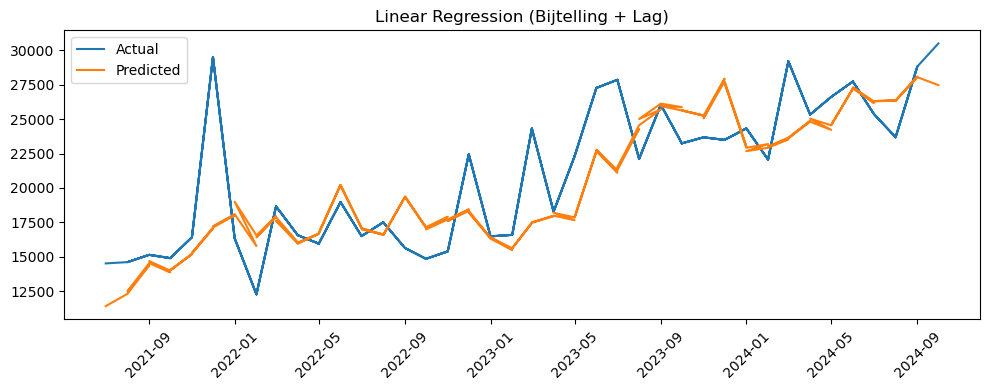

Linear Regression (Confidence + Lag): MAPE=0.1159, MAE=2509.17, RMSE=3605.98, R²=0.482


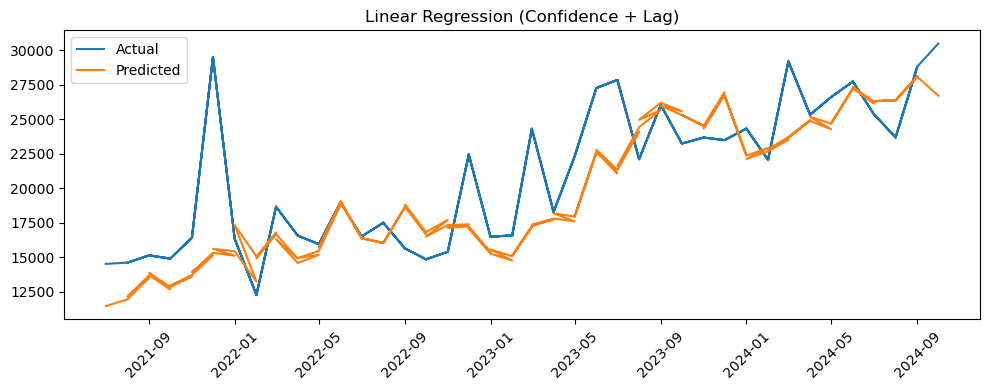

Linear Regression (Fuel + Lag): MAPE=0.1227, MAE=2575.14, RMSE=3482.56, R²=0.517


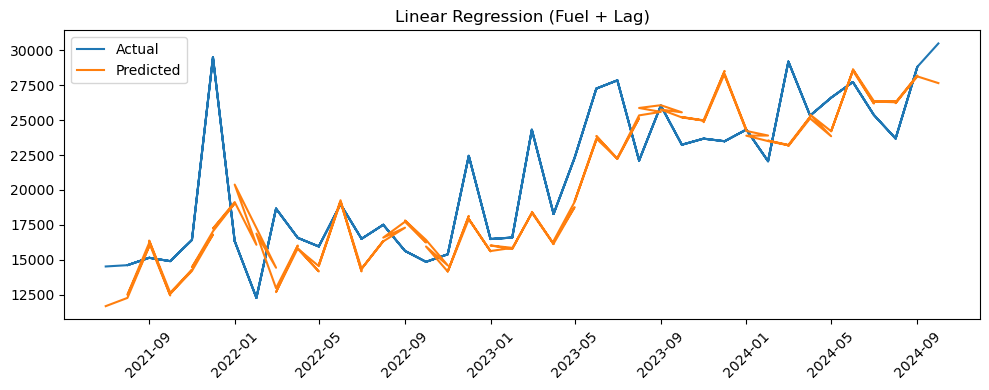

Linear Regression (All Features): MAPE=0.1630, MAE=3309.41, RMSE=4385.07, R²=0.234


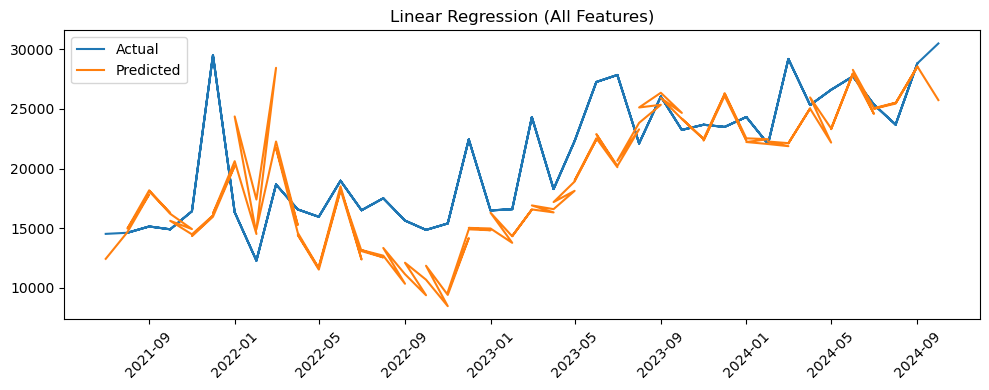

In [ ]:
# for label, features in feature_sets.items():
#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), forecast_horizon=3, validation_size=3
#     )
#     # ...rest van je code...
#     print(f"Linear Regression ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'Linear Regression ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

### XGBOOST

XGBoost ( (Lag Only)): MAPE=0.1222, MAE=2525.05, RMSE=3256.81, R²=0.577


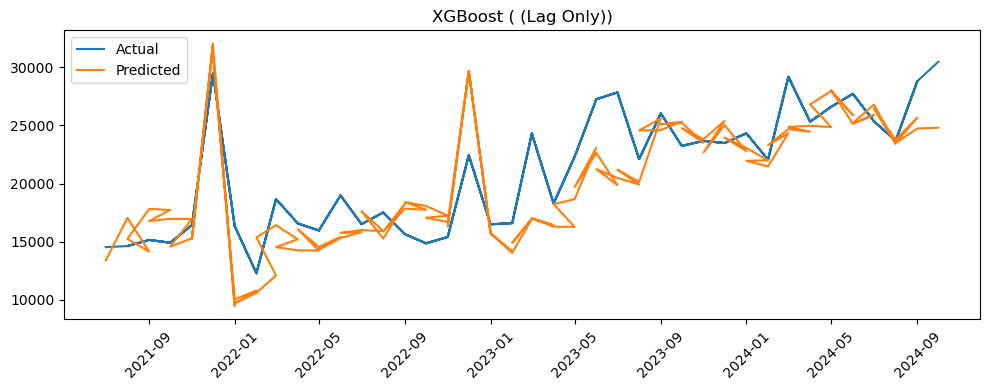

XGBoost (All Features): MAPE=0.1193, MAE=2586.20, RMSE=3556.80, R²=0.496


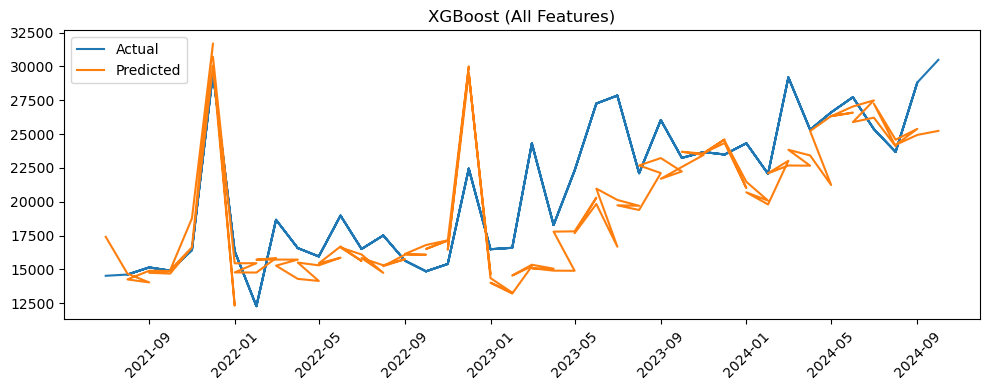

In [18]:
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                                learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
        validation_size=3
    )
    print(f"XGBoost ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(validation_dates, val_actuals, label='Actual')
    plt.plot(validation_dates, val_preds, label='Predicted')
    plt.title(f'XGBoost ({label})')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()       # Ensure there's space for rotated labels
    plt.show()

#### plotting all

In [19]:
# for label, features in feature_sets.items():
#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
#                                 learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
#         validation_size=3
#     )
#     print(f"XGBoost ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'XGBoost ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

### Arimax 

ARIMAX ( (Lag Only)): MAPE=296.0594, MAE=4755171.11, RMSE=25997178.19, R²=-26928609.581


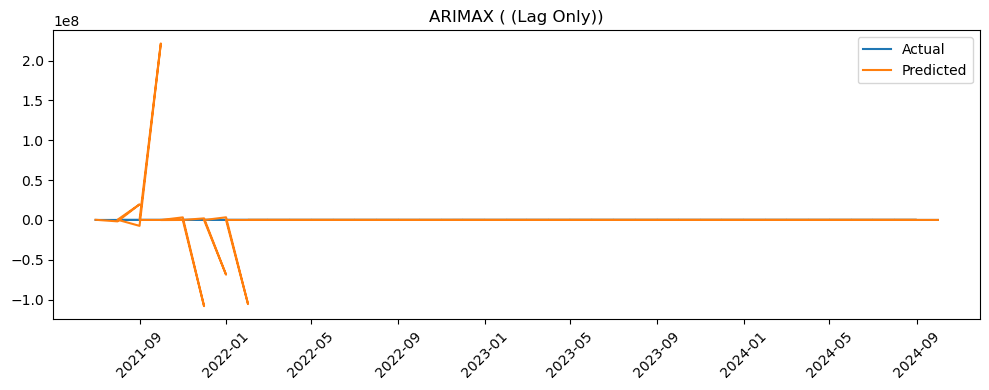

ARIMAX (All Features): MAPE=970.0851, MAE=19524475.33, RMSE=64483428.84, R²=-165675300.385


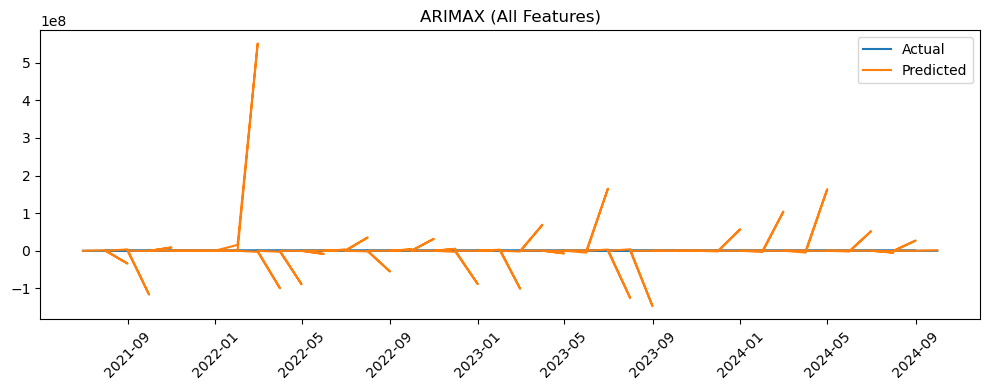

In [21]:

# First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
class ARIMAXWrapper:
    def __init__(self, order=(1,1,1)):
        self.order = order
        self.model_fit = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None:
            raise ValueError("Model not fitted yet")
        # For ARIMAX, predict uses forecast with exog data
        return self.model_fit.forecast(steps=len(X), exog=X)

# Now use this wrapper in your walk-forward validation
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: ARIMAXWrapper(order=(1,1,1)),
        forecast_horizon=3,           # <-- voeg deze toe
        validation_size=3             # <-- en deze
    )
    print(f"ARIMAX ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
  
   
    plt.figure(figsize=(10, 4))
    plt.plot(validation_dates, val_actuals, label='Actual')
    plt.plot(validation_dates, val_preds, label='Predicted')
    plt.title(f'ARIMAX ({label})')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()       # Ensure there's space for rotated labels
    plt.show()

#### Plotting all

In [20]:
# # First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
# class ARIMAXWrapper:
#     def __init__(self, order=(1,1,1)):
#         self.order = order
#         self.model_fit = None
        
#     def fit(self, X, y):
#         from statsmodels.tsa.statespace.sarimax import SARIMAX
#         model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
#         self.model_fit = model.fit(disp=False)
#         return self
        
#     def predict(self, X):
#         if self.model_fit is None:
#             raise ValueError("Model not fitted yet")
#         # For ARIMAX, predict uses forecast with exog data
#         return self.model_fit.forecast(steps=len(X), exog=X)

# # Now use this wrapper in your walk-forward validation
# for label, features in feature_sets.items():
#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: ARIMAXWrapper(order=(1,1,1)),
#         forecast_horizon=3,           # <-- voeg deze toe
#         validation_size=3             # <-- en deze
#     )
#     print(f"ARIMAX ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
  
   
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'ARIMAX ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

## Hyperparameter Tuning

XGboost: zodra gpt weet werkt waardes aanpasssen, alleen parameters aanpassen die meeste invloed hebben  (documantatie over lezen)
https://xgboosting.com/tune-xgboost-learning_rate-parameter/


In [ ]:
from skopt import gp_minimize  # Import Bayesian optimization function from scikit-optimize

# ------------ LAGGED FEATURES OPTIMIZATION ------------

# Define the objective function for walk-forward validation with lagged features only
def wf_objective_lag(params):
    # Unpack hyperparameters from the params list
    max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
    
    # Create an XGBoost regressor with the given hyperparameters
    model = lambda: xgb.XGBRegressor(
        objective='reg:squarederror',           # Use squared error for regression
        max_depth=int(max_depth),               # Maximum tree depth (integer)
        learning_rate=learning_rate,            # Learning rate (float)
        n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
        subsample=subsample,                    # Subsample ratio of the training instances
        min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
        colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
        random_state=42,                        # Set random seed for reproducibility
        eval_metric="rmse"                      # Evaluation metric: root mean squared error
    )
    
    # Get the lag-only features
    lag_features = feature_sets[' (Lag Only)']
    
    # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
    _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
        df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
    )
    return val_mape  # Return validation MAPE to minimize

# ------------ ALL FEATURES OPTIMIZATION ------------

# Define the objective function for walk-forward validation with all features
def wf_objective_all(params):
    # Unpack hyperparameters from the params list
    max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
    
    # Create an XGBoost regressor with the given hyperparameters
    model = lambda: xgb.XGBRegressor(
        objective='reg:squarederror',           # Use squared error for regression
        max_depth=int(max_depth),               # Maximum tree depth (integer)
        learning_rate=learning_rate,            # Learning rate (float)
        n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
        subsample=subsample,                    # Subsample ratio of the training instances
        min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
        colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
        random_state=42,                        # Set random seed for reproducibility
        eval_metric="rmse"                      # Evaluation metric: root mean squared error
    )
    
    # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
    _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
        df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
    )
    return val_mape  # Return validation MAPE to minimize

# Define the search space for each hyperparameter (same for both feature sets)
wf_space = [
    (3, 7),                 # max_depth: beperk de diepte voor stabiliteit en interpretatie
    (0.005, 0.15),          # learning_rate: lagere learning rate voorkomt overfitten, vooral bij veel bomen
    (100, 400),             # n_estimators: ruim bereik om early stopping te benutten als je dat later toevoegt
    (0.7, 1.0),             # subsample: iets onder 1.0 voor regularisatie
    (2, 10),                # min_child_weight: vanaf 2 om splitsing op ruis te voorkomen
    (0.6, 1.0)              # colsample_bytree: hoger dan normaal omdat je relatief weinig features hebt
]


# Run Bayesian optimization to find the best hyperparameters for lag-only features
print("\n--- Starting optimization for lag-only features ---")
wf_result_lag = gp_minimize(wf_objective_lag, wf_space, n_calls=25, random_state=42)

# Run Bayesian optimization to find the best hyperparameters for all features
print("\n--- Starting optimization for all features ---")
wf_result_all = gp_minimize(wf_objective_all, wf_space, n_calls=25, random_state=42)

# Print the best hyperparameters and the corresponding best MAPE for lag-only features
print("\n----- RESULTS -----")
print(f"\nBest parameters (Lag-Only Features): max_depth={int(wf_result_lag.x[0])}, learning_rate={wf_result_lag.x[1]:.4f}, "
      f"n_estimators={int(wf_result_lag.x[2])}, subsample={wf_result_lag.x[3]:.2f}, "
      f"min_child_weight={int(wf_result_lag.x[4])}, colsample_bytree={wf_result_lag.x[5]:.2f}")
print(f"Best MAPE (Lag-Only Features): {wf_result_lag.fun:.4f}")

# Print the best hyperparameters and the corresponding best MAPE for all features
print(f"\nBest parameters (All Features): max_depth={int(wf_result_all.x[0])}, learning_rate={wf_result_all.x[1]:.4f}, "
      f"n_estimators={int(wf_result_all.x[2])}, subsample={wf_result_all.x[3]:.2f}, "
      f"min_child_weight={int(wf_result_all.x[4])}, colsample_bytree={wf_result_all.x[5]:.2f}")
print(f"Best MAPE (All Features): {wf_result_all.fun:.4f}")

# Compare models with optimized parameters
print("\n----- EVALUATING MODELS WITH OPTIMIZED PARAMETERS -----")

# Define optimized models
lag_opt_model = lambda: xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=int(wf_result_lag.x[0]),
    learning_rate=wf_result_lag.x[1],
    n_estimators=int(wf_result_lag.x[2]),
    subsample=wf_result_lag.x[3],
    min_child_weight=int(wf_result_lag.x[4]),
    colsample_bytree=wf_result_lag.x[5],
    random_state=42,
    eval_metric="rmse"
)

all_opt_model = lambda: xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=int(wf_result_all.x[0]),
    learning_rate=wf_result_all.x[1],
    n_estimators=int(wf_result_all.x[2]),
    subsample=wf_result_all.x[3],
    min_child_weight=int(wf_result_all.x[4]),
    colsample_bytree=wf_result_all.x[5],
    random_state=42,
    eval_metric="rmse"
)

# Evaluate the model with lag-only features and its optimized parameters
lag_features = feature_sets[' (Lag Only)']
_, _, _, _, _, _, lag_mae, _, _, lag_mape, lag_preds, lag_actuals, lag_dates = walk_forward_validation_with_validation_set(
    df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', lag_opt_model, validation_size=3, forecast_horizon=3
)
print(f"Optimized XGBoost (Lag-Only): MAPE={lag_mape:.4f}, MAE={lag_mae:.2f}")

# Evaluate the model with all features and its optimized parameters
_, _, _, _, _, _, all_mae, _, _, all_mape, all_preds, all_actuals, all_dates = walk_forward_validation_with_validation_set(
    df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', all_opt_model, validation_size=3, forecast_horizon=3
)
print(f"Optimized XGBoost (All Features): MAPE={all_mape:.4f}, MAE={all_mae:.2f}")

# Plot results for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lag_dates, lag_actuals, label='Actual')
plt.plot(lag_dates, lag_preds, label='Predicted')
plt.title(f'Optimized XGBoost (Lag-Only)\nMAPE={lag_mape:.4f}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(all_dates, all_actuals, label='Actual')
plt.plot(all_dates, all_preds, label='Predicted')
plt.title(f'Optimized XGBoost (All Features)\nMAPE={all_mape:.4f}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


--- Starting optimization for lag-only features ---

--- Starting optimization for all features ---

----- RESULTS -----

Best parameters (Lag-Only Features): max_depth=5, learning_rate=0.0434, n_estimators=240, subsample=1.00, min_child_weight=10, colsample_bytree=0.76
Best MAPE (Lag-Only Features): 0.1233

Best parameters (All Features): max_depth=5, learning_rate=0.0534, n_estimators=143, subsample=0.90, min_child_weight=2, colsample_bytree=0.89
Best MAPE (All Features): 0.1203

----- EVALUATING MODELS WITH OPTIMIZED PARAMETERS -----
Optimized XGBoost (Lag-Only): MAPE=0.1404, MAE=3031.18


TypeError: walk_forward_validation_with_validation_set() got an unexpected keyword argument 'forcast_horizon'

### Shap

# Test

### LR

In [1]:
# Alleen de labels " (Lag Only)" en "All Features" verwerken
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
    )

    print(f"Linear Regression ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(validation_dates, val_actuals, label='Actual')
    plt.plot(validation_dates, val_preds, label='Predicted')
    plt.title(f'Linear Regression ({label})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


NameError: name 'feature_sets' is not defined

Linear Regression ( (Lag Only)): MAPE=0.1117, MAE=2546.43, RMSE=3521.89, R²=0.677


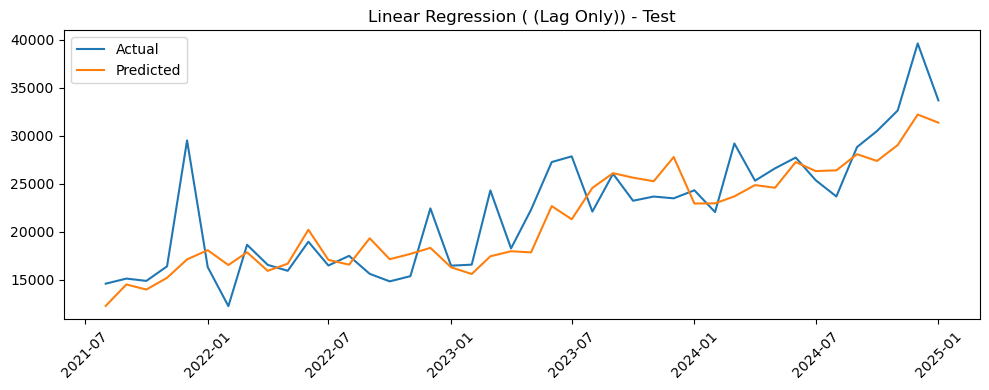

Linear Regression (Keywords + Lag): MAPE=0.1337, MAE=3042.31, RMSE=4226.67, R²=0.535


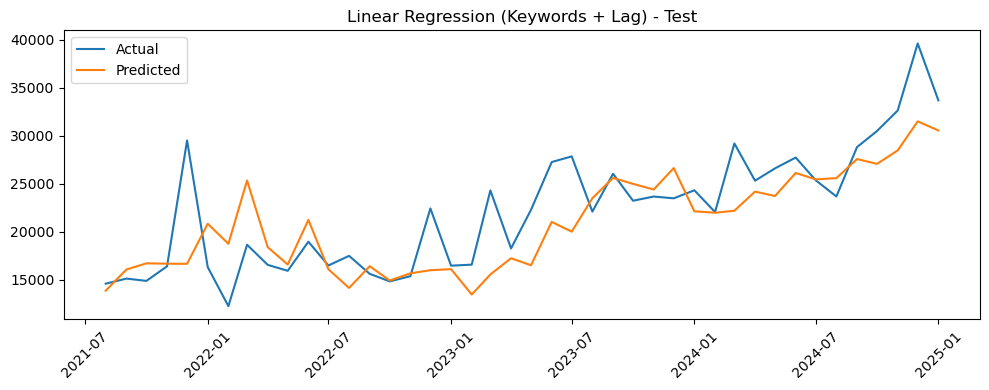

Linear Regression (Bijtelling + Lag): MAPE=0.1118, MAE=2552.88, RMSE=3529.13, R²=0.676


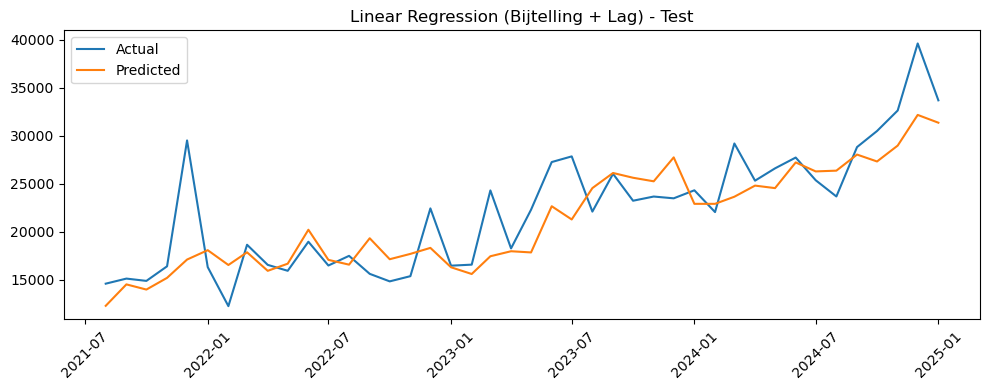

Linear Regression (Confidence + Lag): MAPE=0.1203, MAE=2784.75, RMSE=3871.54, R²=0.610


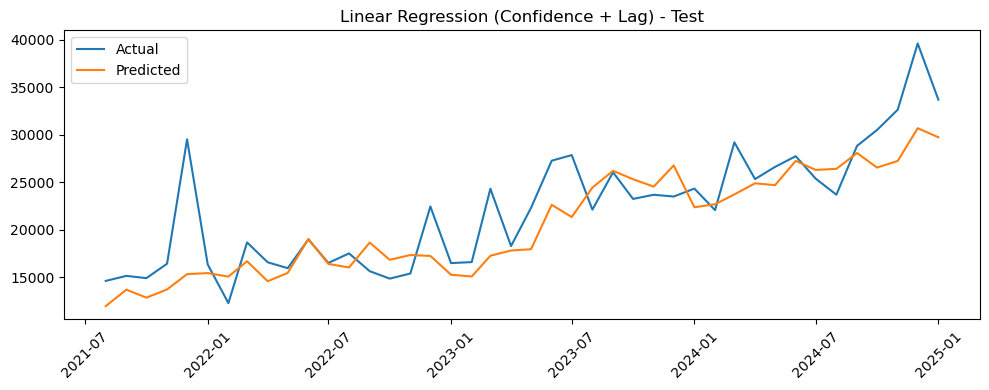

Linear Regression (Fuel + Lag): MAPE=0.1228, MAE=2713.82, RMSE=3589.39, R²=0.665


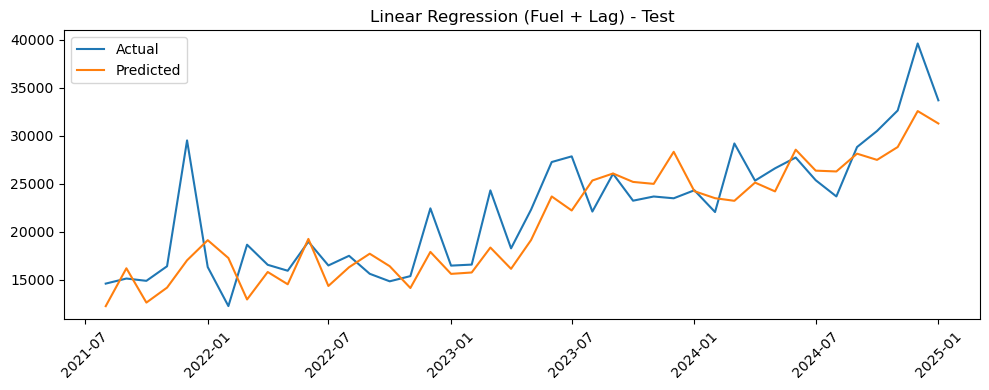

Linear Regression (All Features): MAPE=0.1632, MAE=3562.65, RMSE=4652.30, R²=0.437


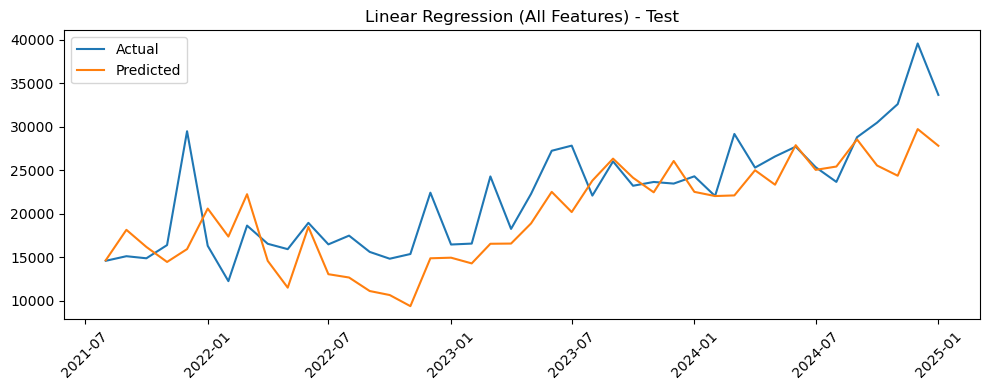

In [ ]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, test_mape, val_preds, test_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
    )
    print(f"Linear Regression ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'Linear Regression ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Arimax

ARIMAX ( (Lag Only)): MAPE=1.2403, MAE=20805.91, RMSE=57715.63, R²=-85.693


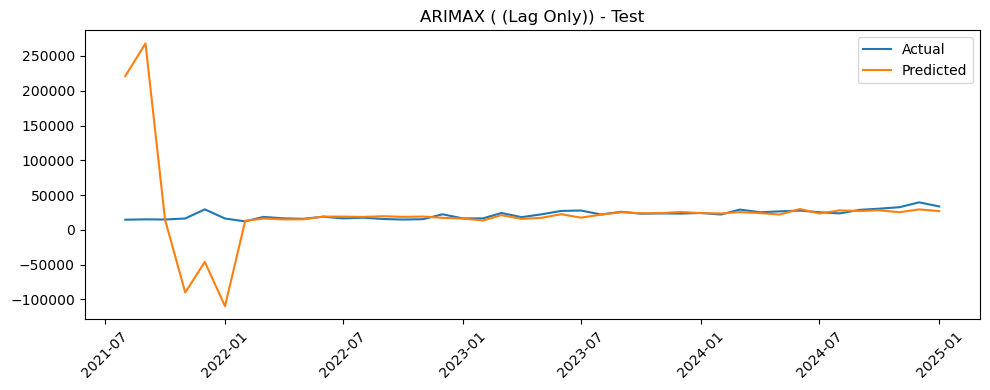

ARIMAX (Keywords + Lag): MAPE=0.1354, MAE=3177.50, RMSE=4336.23, R²=0.511


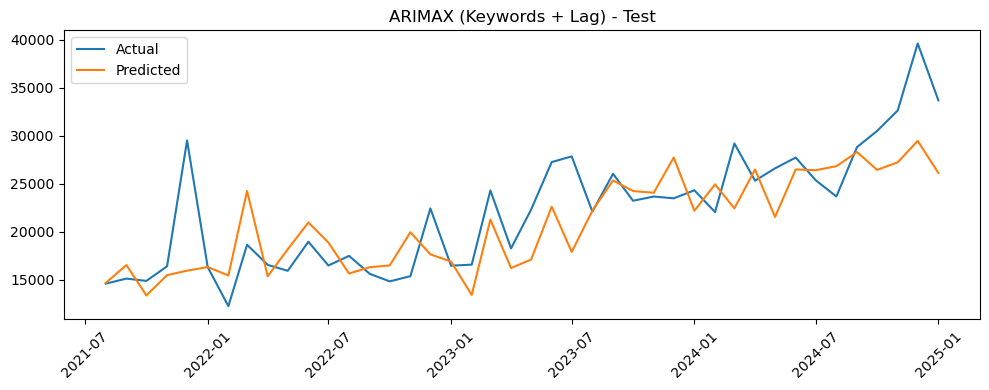

ARIMAX (Bijtelling + Lag): MAPE=0.1244, MAE=2943.09, RMSE=4080.55, R²=0.567


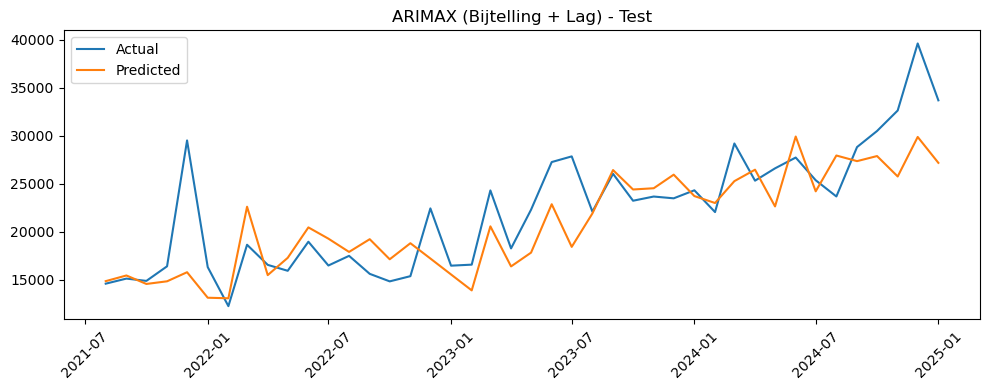

ARIMAX (Confidence + Lag): MAPE=3.3169, MAE=76249.26, RMSE=109931.91, R²=-313.517


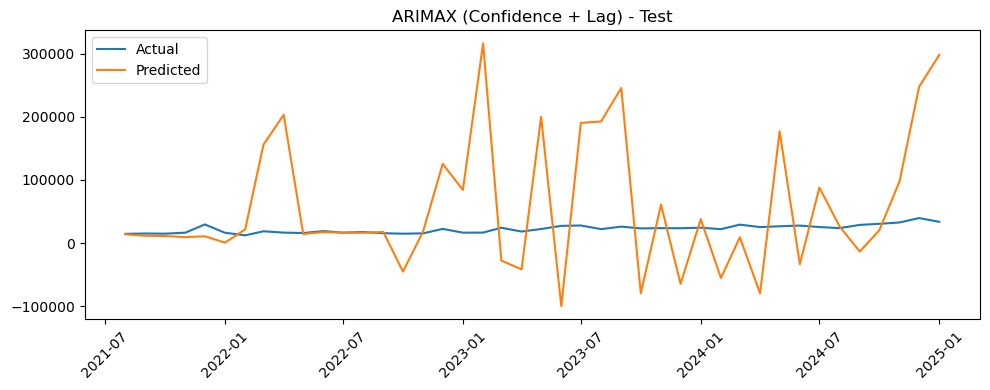

ARIMAX (Fuel + Lag): MAPE=0.1224, MAE=2863.31, RMSE=4125.82, R²=0.557


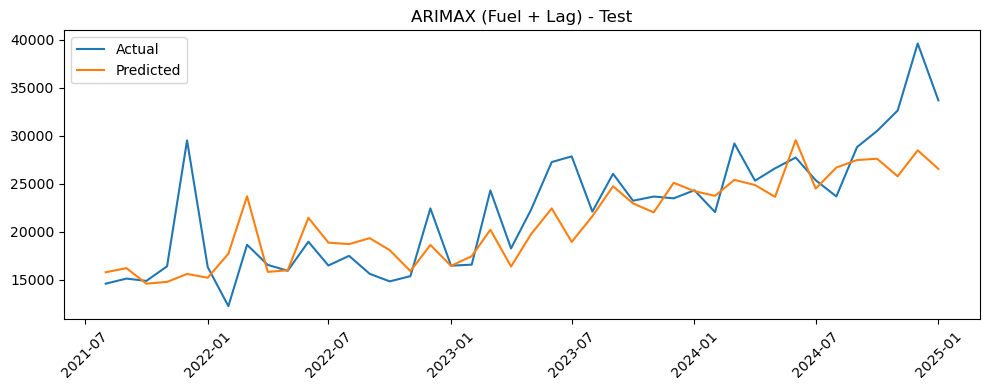

ARIMAX (All Features): MAPE=2.7928, MAE=50469.91, RMSE=89580.84, R²=-207.847


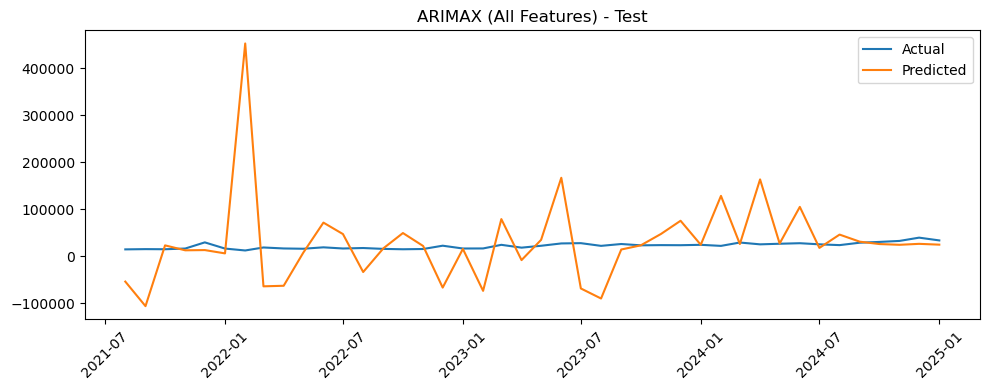

In [ ]:
# First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
class ARIMAXWrapper:
    def __init__(self, order=(1,1,1)):
        self.order = order
        self.model_fit = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None:
            raise ValueError("Model not fitted yet")
        # For ARIMAX, predict uses forecast with exog data
        return self.model_fit.forecast(steps=len(X), exog=X)

# Now use this wrapper in your walk-forward validation to evaluate on the test set.
for label, features in feature_sets.items():
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: ARIMAXWrapper(order=(1,1,1)),
        validation_size=1
    )
    print(f"ARIMAX ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'ARIMAX ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### XGboost

#### parameters for lag only 

XGBoost ( (Lag Only)): MAPE=0.1779, MAE=4195.10, RMSE=5381.39, R²=0.133


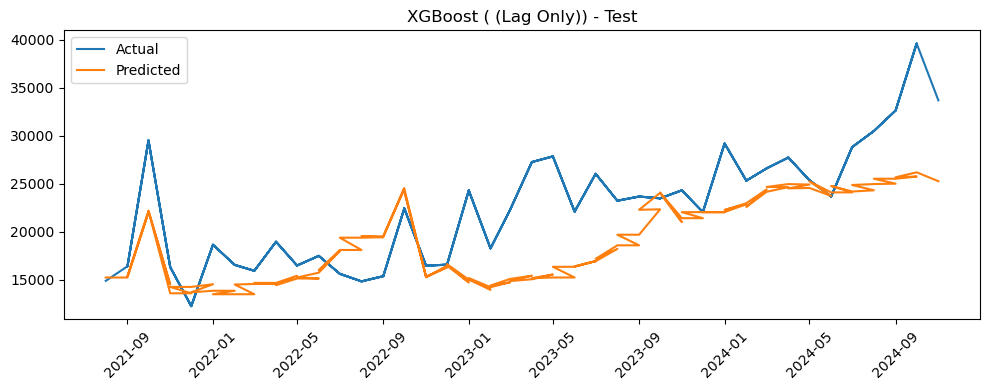

XGBoost (Keywords + Lag): MAPE=0.1935, MAE=4554.22, RMSE=5786.04, R²=-0.002


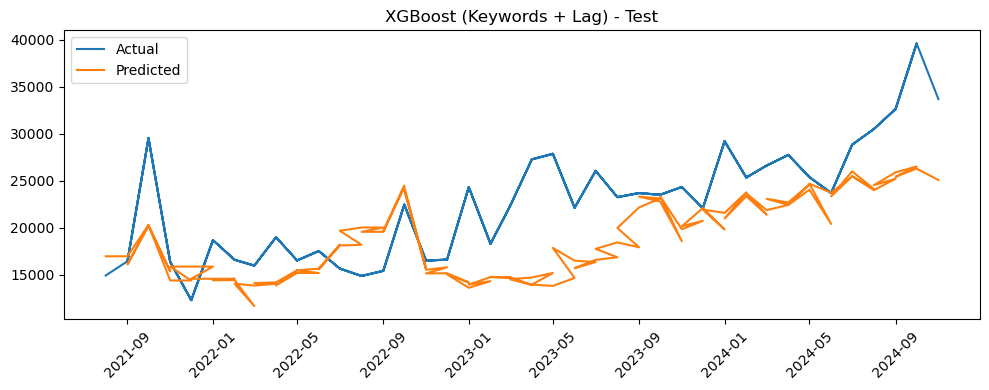

XGBoost (Bijtelling + Lag): MAPE=0.1811, MAE=4251.63, RMSE=5426.15, R²=0.119


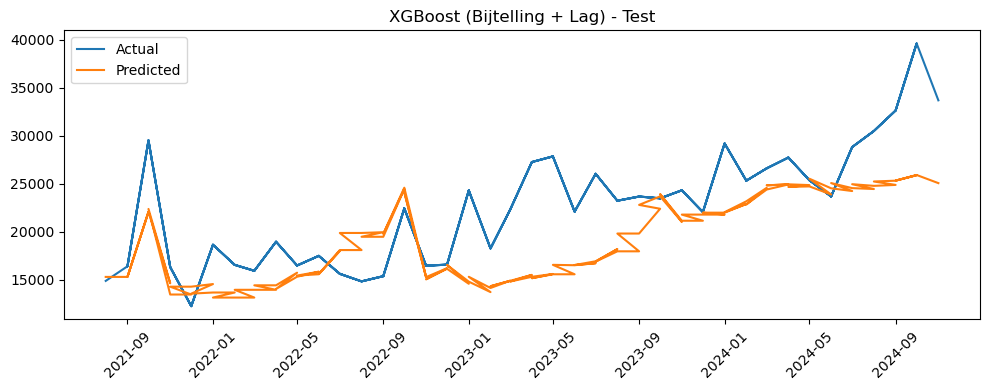

XGBoost (Confidence + Lag): MAPE=0.2124, MAE=5078.41, RMSE=6301.26, R²=-0.189


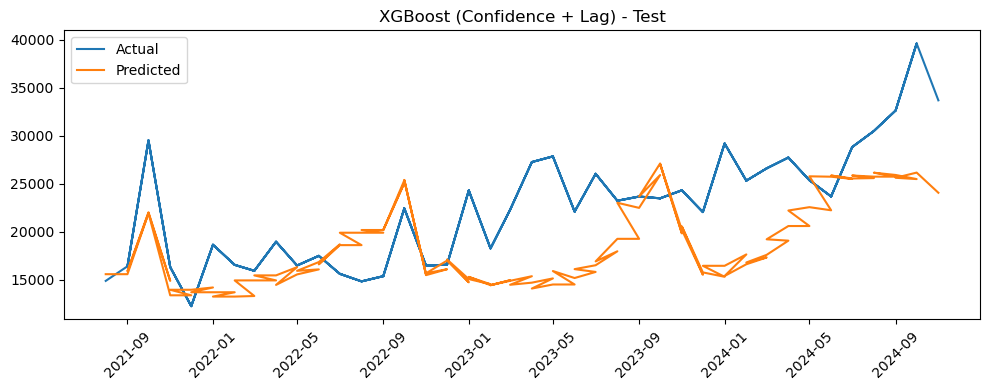

XGBoost (Fuel + Lag): MAPE=0.1994, MAE=4659.48, RMSE=5874.36, R²=-0.033


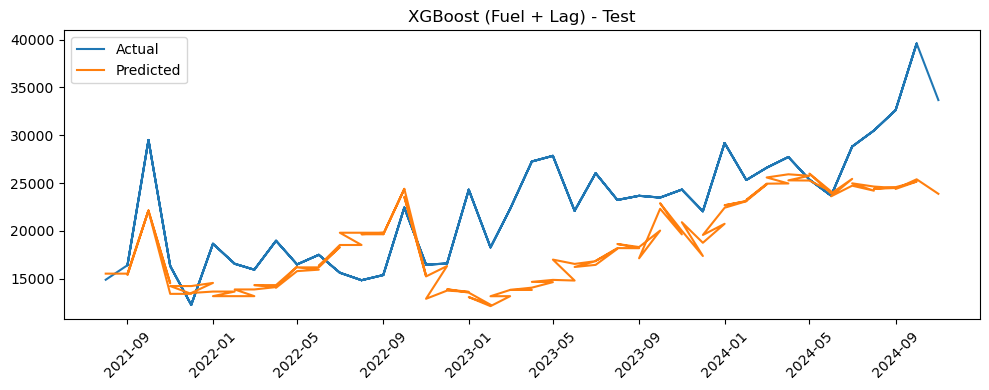

XGBoost (All Features): MAPE=0.2188, MAE=5229.79, RMSE=6475.59, R²=-0.255


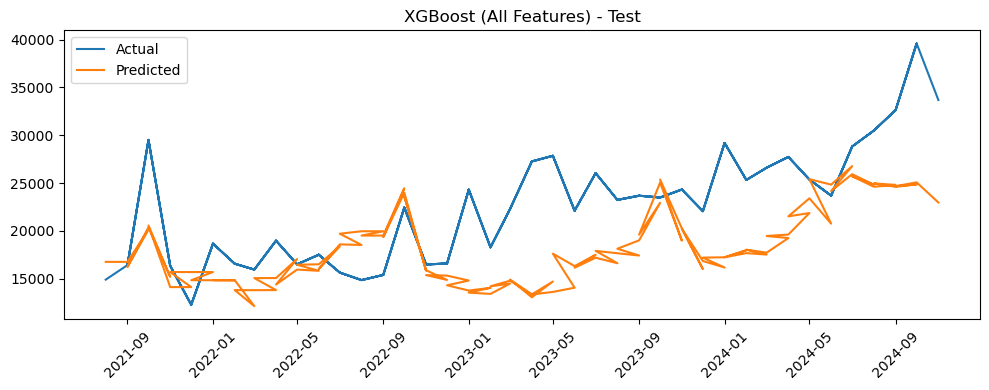

In [24]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=5, learning_rate=0.0434, n_estimators=240, subsample=1, min_child_weight=10, colsample_bytree=0.76, 
            eval_metric="rmse"
        ),
        validation_size=3, forecast_horizon=3
    )
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'XGBoost ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### parameters for all features

XGBoost ( (Lag Only)): MAPE=0.1605, MAE=3727.01, RMSE=4665.87, R²=0.433


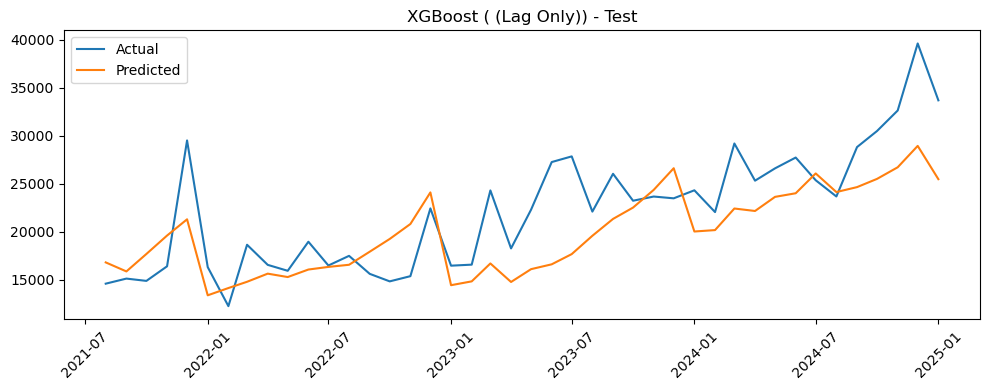

XGBoost (Keywords + Lag): MAPE=0.1550, MAE=3694.20, RMSE=4942.81, R²=0.364


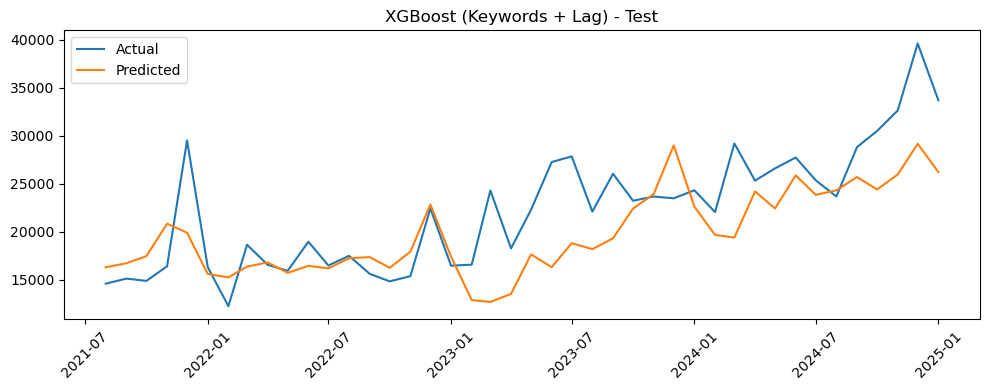

XGBoost (Bijtelling + Lag): MAPE=0.1671, MAE=3821.13, RMSE=4842.20, R²=0.390


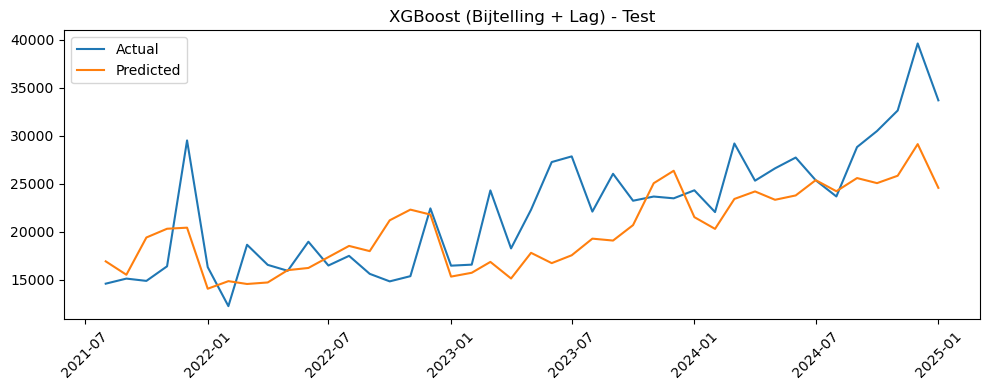

XGBoost (Confidence + Lag): MAPE=0.1619, MAE=3676.61, RMSE=4655.30, R²=0.436


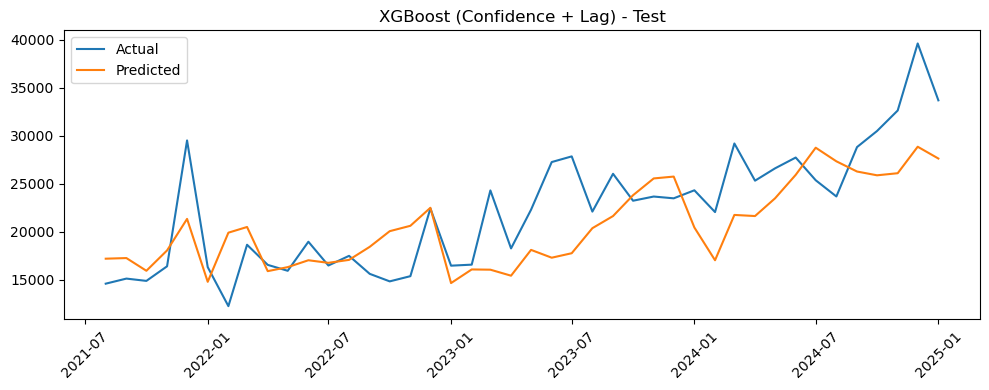

XGBoost (Fuel + Lag): MAPE=0.1535, MAE=3634.59, RMSE=4665.89, R²=0.433


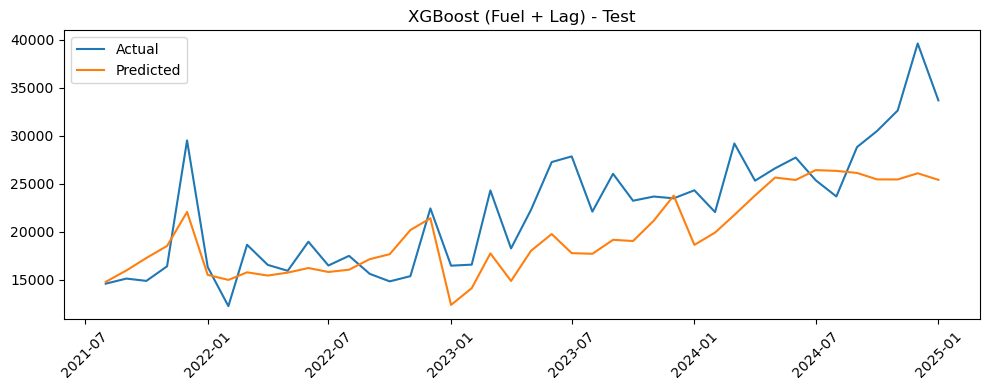

XGBoost (All Features): MAPE=0.1828, MAE=4119.40, RMSE=5257.37, R²=0.281


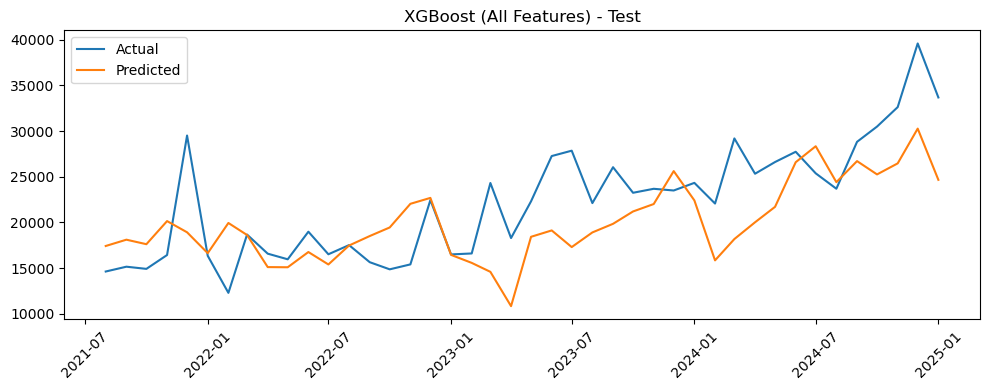

In [ ]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=3, learning_rate=0.2543, n_estimators=106, subsample=0.50, min_child_weight=8, colsample_bytree=0.39, 
            eval_metric="rmse"
        ),
        validation_size=1
    )
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'XGBoost ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()